[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

#  Adaptive Boosting

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 11/04/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0056EnsembleAdaptiveBoosting.ipynb)

In [6]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.datasets import fetch_openml
from sklearn.ensemble import AdaBoostClassifier

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [7]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())


In [8]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2


In [9]:
# Courses Packages


In [10]:
# General Auxiliary Functions
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from utils.DataVisualization import PlotBinaryClassData, PlotDecisionBoundaryClosure


## Ada Boost Classification

In this note book we'll use the _AdaBoost_ based classifier.  
The _AdaBoost_ concept optimizes a sequence of estimators by optimizing the weights of the data at each iteration.

* <font color='brown'>(**#**)</font> The _AdaBoost_ method is a specific case of the _Gradient Boosting_ method.
* <font color='brown'>(**#**)</font> The main disadvantage of the _AdaBoost_ (And _Gradient Boosting_) method is the sequential stacking of the models.

In [11]:
# Parameters

# Data
numSamplesCls = 500

# Model
numEst = 150
adaBoostAlg = 'SAMME'

# Data Visualization
numGridPts = 500


## Generate / Load Data


In [12]:
# Generate Data

vN    = np.sqrt(np.random.rand(numSamplesCls, 1)) * 480 * 2 * (np.pi / 360)
vCos  = -vN * np.cos(vN) + np.random.rand(numSamplesCls, 1) / 2
vSin  =  vN * np.sin(vN) + np.random.rand(numSamplesCls, 1) / 2
mX1   =  np.c_[vCos, vSin]
mX2   = -np.c_[vCos, vSin]
mX    =  np.r_[mX1, mX2]
vY    =  np.r_[-np.ones(numSamplesCls), np.ones(numSamplesCls)]

numSamples = np.size(vY)

vIdx0 = vY == -1
vIdx1 = vY ==  1

print(f'The features data shape: {mX.shape}')
print(f'The labels data shape: {vY.shape}')

# Decision Boundary Plotter
PlotDecisionBoundary = PlotDecisionBoundaryClosure(numGridPts, mX[:, 0].min(), mX[:, 0].max(), mX[:, 1].min(), mX[:, 1].max())

The features data shape: (1000, 2)
The labels data shape: (1000,)


### Plot Data

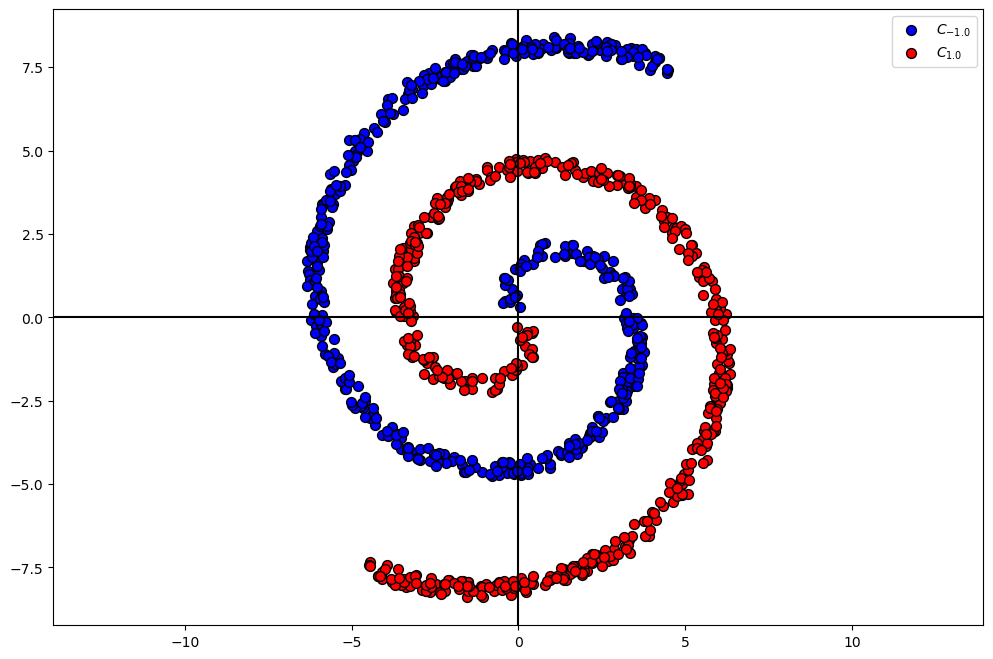

In [13]:
# Plot the Data

hF, hA = plt.subplots(figsize = (12, 8))

hA = PlotBinaryClassData(mX, vY, hA = hA)


* <font color='red'>(**?**)</font> Is there a simple feature engineering to make the data set linearly separable?

## Train an Ada Boosting Model

The model is attributes are:

$$
\begin{align*}
\text{Train error} & =\frac{1}{N}\sum_{i=1}^{N}\mathbb{I}\left\{ \hat{y}_{i}\neq y\right\} \\
\text{Train loss} & =\frac{1}{N}\sum_{i=1}^{N}\exp\left(-y_{i}H\left(\boldsymbol{x}_{i}\right)\right)\\
\hat{y}_{i} & =\text{sign}\left(H\left(\boldsymbol{x}_{i}\right)\right)
\end{align*}
$$



In [14]:
# Constructing and Training the Model
oAdaBoost = AdaBoostClassifier(n_estimators = numEst, algorithm = adaBoostAlg)
oAdaBoost = oAdaBoost.fit(mX, vY)

In [15]:
# Plot the Model by Number of Estimators

def PlotAdaBoost( numEst: int, oAdaBoostCls: AdaBoostClassifier, mX: np.ndarray, vY: np.ndarray, numGridPts: int ):
    
    def Predict(oAdaBoost: AdaBoostClassifier, numEst: int, mX: np.ndarray, vY: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        numSamples  = mX.shape[0]
        vW          = np.ones(numSamples) / numSamples
        vH          = np.zeros(numSamples)
        vTrainErr   = np.full(numEst, np.nan)
        vLoss       = np.full(numEst, np.nan)
        for mm in range(numEst):
            α_m = oAdaBoost.estimator_weights_[mm]
            h_m     = oAdaBoost.estimators_[mm]
            vHatYm  = h_m.predict(mX)
            vH     += α_m * vHatYm

            if vY is not None:
                vW             = vW * np.exp(-α_m * vY * h_m.predict(mX)) #<! Weights per sample
                vW            /= np.sum(vW)
                vTrainErr[mm]  = np.mean(np.sign(vH) != vY)
                vLoss[mm]      = np.mean(np.exp(-vH * vY))
        
        vH = np.sign(vH)
        
        return vH, vW, vTrainErr, vLoss
        
    v0       = np.linspace(mX[:,0].min(), mX[:,0].max(), numGridPts)
    v1       = np.linspace(mX[:,1].min(), mX[:,1].max(), numGridPts)
    XX0, XX1 = np.meshgrid(v0, v1)
    XX       = np.c_[XX0.ravel(), XX1.ravel()]

    _, vW, vTrainErr, vLoss = Predict(oAdaBoostCls, numEst, mX, vY)
    ZZ                      = Predict(oAdaBoostCls, numEst, XX)[0]
    ZZ                      = np.reshape(ZZ, XX0.shape)

    numSamples = np.size(mX, 0)

    plt.figure  (figsize = (12, 5))
    plt.subplot (1, 2, 1)
    plt.contourf(XX0, XX1, ZZ, colors = ['red', 'blue'], alpha = 0.3)
    plt.scatter (mX[vIdx0, 0], mX[vIdx0, 1], s = 50 * numSamples * vW[vIdx0], color = 'r', edgecolors = 'k')
    plt.scatter (mX[vIdx1, 0], mX[vIdx1, 1], s = 50 * numSamples * vW[vIdx1], color = 'b', edgecolors = 'k')
    plt.title   ('$M = ' + str(numEst) + '$')
                                        
    plt.subplot(1,2,2)
    plt.plot   (vTrainErr, 'b', lw = 2, label = 'Train Error')
    plt.plot   (vLoss,     'r', lw = 2, label = 'Train Loss')
    plt.grid   ()
    plt.legend ()
    
    plt.tight_layout()
    plt.show        ()

In [16]:
# Plotting Wrapper

hPlotAdaBoost = lambda numEst: PlotAdaBoost(numEst, oAdaBoost, mX, vY, numGridPts)

In [17]:
# Interactive Plot
mSlider = IntSlider(min = 1, max = numEst, step = 1, value = 1, layout = Layout(width = '80%'))
interact(hPlotAdaBoost, numEst = mSlider);

plt.show()

interactive(children=(IntSlider(value=1, description='numEst', layout=Layout(width='80%'), max=150, min=1), Ou…